In [1]:
using PyPlot, CALCEPH, DelimitedFiles
# using Statistics, DataFitting, Random
# using Unitful, UnitfulAstro, LinearAlgebra
using PyCall

include("/Users/bethleelindor/work/washington/ttv_project/ttv_ss/CGS.jl")
include("/Users/bethleelindor/work/washington/ttv_project/ttv_ss/regress.jl")

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


regress (generic function with 1 method)

In [40]:
include("sim_times.jl")

sim_times (generic function with 1 method)

In [3]:
sigma,nyear=10.0,15.0
datafile=readdlm("ttv_ss/INPUTS/tt_10.0snoEMB15.0yrs.txt",Float64)

41×4 Array{Float64,2}:
 1.0  2.4335e6   2.4335e6   0.000115741
 1.0  2.43373e6  2.43373e6  0.000115741
 1.0  2.43395e6  2.43395e6  0.000115741
 1.0  2.43418e6  2.43418e6  0.000115741
 1.0  2.4344e6   2.4344e6   0.000115741
 1.0  2.43463e6  2.43463e6  0.000115741
 1.0  2.43485e6  2.43485e6  0.000115741
 1.0  2.43508e6  2.43508e6  0.000115741
 1.0  2.4353e6   2.4353e6   0.000115741
 1.0  2.43553e6  2.43553e6  0.000115741
 1.0  2.43575e6  2.43575e6  0.000115741
 1.0  2.43598e6  2.43598e6  0.000115741
 1.0  2.4362e6   2.4362e6   0.000115741
 ⋮                                     
 2.0  2.43509e6  2.43509e6  0.000115741
 2.0  2.43545e6  2.43545e6  0.000115741
 2.0  2.43582e6  2.43582e6  0.000115741
 2.0  2.43618e6  2.43618e6  0.000115741
 2.0  2.43655e6  2.43655e6  0.000115741
 2.0  2.43691e6  2.43691e6  0.000115741
 2.0  2.43728e6  2.43728e6  0.000115741
 2.0  2.43764e6  2.43764e6  0.000115741
 2.0  2.43801e6  2.43801e6  0.000115741
 2.0  2.43837e6  2.43837e6  0.000115741
 2.0  2.43874e6  

In [4]:
nt1 = sum(datafile[:,1] .== 1.0)
nt2 = sum(datafile[:,1] .== 2.0)
tcalc1,tobs1 = vec(datafile[1:nt1,2]),vec(datafile[1:nt1,3])
tcalc2,tobs2 = vec(datafile[nt1+1:nt1+nt2,2]),vec(datafile[nt1+1:nt1+nt2,3])

([2.4336244081301526e6, 2.433989664529084e6, 2.434354920928016e6, 2.4347201773269475e6, 2.4350854337258786e6, 2.43545069012481e6, 2.435815946523742e6, 2.4361812029226734e6, 2.436546459321605e6, 2.4369117157205367e6, 2.4372769721194683e6, 2.4376422285183994e6, 2.438007484917331e6, 2.4383727413162626e6, 2.4387379977151942e6, 2.439103254114126e6], [2.433624410904252e6, 2.4339896632245057e6, 2.434354923615751e6, 2.4347201748723397e6, 2.435085434042626e6, 2.4354506932529067e6, 2.43581594201368e6, 2.436181201146552e6, 2.4365464581534583e6, 2.436911712080265e6, 2.4372769748899196e6, 2.437642228357363e6, 2.438007485628231e6, 2.4383727455315217e6, 2.4387379953219397e6, 2.439103255326047e6])

Modified sim_times.jl 
Changed calculation of coefficients from  $x[2,i] = x[2,i-1] + round((tt[i]-tt[i-1])/Period) $ to $x[2,i] = round((tt[i]-tt[1])/period) $

In [41]:
jd1=2.4332825e6
sigma=30; nyear=30; obs="fromEMB"
eph = Ephem("INPUTS/DE440.bsp") ; prefetch(eph)
options = useNaifId+unitKM+unitDay # useNaifId + unitDay + unitAU
AU = 149597870.700 #km

jd2 = nyear*365.25 + jd1
jdsize = 1000
# dt = (jd2 - jd1)/jdsize
@assert (jd1 >= 2287184.5) #2414105.0
@assert (jd2 <= 2688976.5) #2488985.0
t0 = range(jd1,stop=jd2-1,length = jdsize)

# Compute ephemerides of Sun, Venus and Earth (or EMB):
pva_sun = zeros(9,jdsize)
pva_venus = zeros(9,jdsize)
pva_earth = zeros(9,jdsize)
for i=1:jdsize
pva_sun[1:9,i] = compute(eph,t0[i],0.5,10,10,options,2)./AU
pva_venus[1:9,i] = compute(eph,t0[i],0.5,2,10,options,2)./AU
pva_earth[1:9,i] = compute(eph,t0[i],0.5,3,10,options,2)./AU
end

# Find observer location required to see transits:
L_venus = cross(pva_venus[1:3],pva_venus[4:6])
L_earth = cross(pva_earth[1:3],pva_earth[4:6])
n_obs = cross(L_earth,L_venus)
n_obs /= norm(n_obs) #from one direction when both transit
x_obs,y_obs,z_obs = n_obs[1],n_obs[2],n_obs[3]

(0.22607070756254913, 0.8936832885768102, 0.3875851066549205)

In [42]:
P_venus = 225.0
P_earth = 365.0
P_err = 2.0
i=1
JD_venus,ff_venus,i_min_venus,pos_venus,tt_venus = find_transit(2,eph,t0[i],t0[i]+365,n_obs,365)
JD_earth,ff_earth,i_min_earth,pos_earth,tt_earth = find_transit(3,eph,t0[i],t0[i]+365,n_obs,365)

([2.4332825e6, 2.4332835027472526e6, 2.4332845054945056e6, 2.433285508241758e6, 2.433286510989011e6, 2.433287513736264e6, 2.4332885164835164e6, 2.433289519230769e6, 2.433290521978022e6, 2.4332915247252746e6  …  2.4336384752747254e6, 2.433639478021978e6, 2.433640480769231e6, 2.4336414835164836e6, 2.433642486263736e6, 2.433643489010989e6, 2.433644491758242e6, 2.4336454945054944e6, 2.4336464972527474e6, 2.4336475e6], [0.006343746899744841, 0.00654751419962324, 0.006743083926010962, 0.006930211999892349, 0.007108665174569279, 0.007278221342844428, 0.007438669828844608, 0.007589811664784141, 0.0077314598509412155, 0.007863439599338468  …  0.004116942308151672, 0.004383240315756116, 0.004644052890843938, 0.004899052844535854, 0.005147920320137385, 0.005390343219338764, 0.005626017618144214, 0.005854648172874496, 0.0060759485136030154, 0.006289641625508581], 342, [-0.18270197778471872 -0.19990557988308225 … -0.1609801873890232 -0.17825408122328493; 0.8863776636217706 0.883239595171651 … 0.889

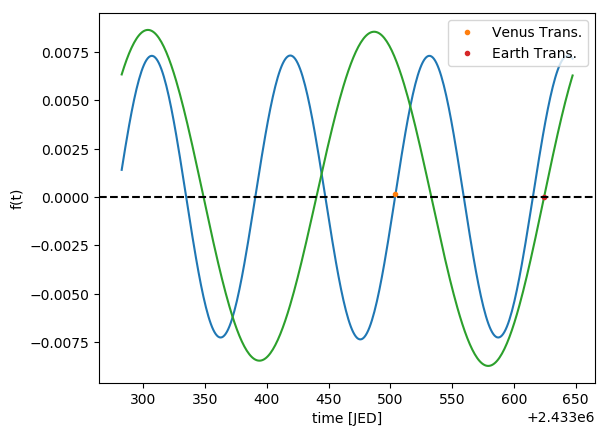

PyObject <matplotlib.legend.Legend object at 0x1476d64a8>

In [43]:
plot(JD_venus,ff_venus)
plot(JD_venus[i_min_venus],ff_venus[i_min_venus],".",label="Venus Trans.")
plot(JD_earth,ff_earth)
plot(JD_earth[i_min_earth],ff_earth[i_min_earth],".",label="Earth Trans.")
axhline(0.0,linestyle="--",color="black")
ylabel("f(t)")
xlabel("time [JED]")
legend()

(0.0001413192917627164, 9.589769276704572e-6)

In [45]:
# Find actual transit times:
tt2 = find_times(3, eph, t0, P_earth, P_err, n_obs, 10)
tt1 = find_times(2, eph, t0, P_venus, P_err, n_obs, 10)
sigtt1=fixed_noise(tt1,sigma)
sigtt2=fixed_noise(tt2,sigma)

x1,t01,per1 = linear_fit(tt1,P_venus,sigtt1)
x2,t02,per2 = linear_fit(tt2,P_earth,sigtt2)
tt=[tt1;tt2]

# Best-fit linear transit times:
nt1=length(tt1) ; nt2=length(tt2)
t1  = collect(t01 .+ per1 .* range(0,stop=nt1-1,length=nt1)) 
t2  = collect(t02 .+ per2 .* range(0,stop=nt2-1,length=nt2))
tt0 = [t1;t2]
sigtt=[sigtt1;sigtt2];

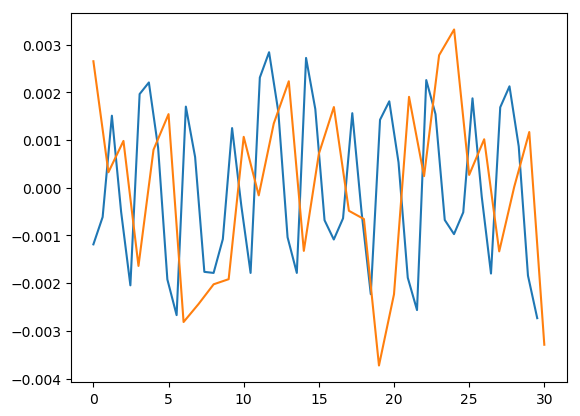

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1467bfe48>

In [46]:
ttv1=calc_ttvs_given_per_est(tt1,P_venus,sigtt1)
ttv2=calc_ttvs_given_per_est(tt2,P_earth,sigtt2)  
plot((t1.-t01)/per2,ttv1)
plot((t2.-t02)/per2,ttv2)

In [47]:
test_sim_obs_and_find_times()

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [2.433503765569623e6, 2.433728466315147e6, 2.4339531670606714e6, 2.4341778678061953e6, 2.4344025685517197e6, 2.4346272692972436e6, 2.434851970042768e6, 2.435076670788292e6, 2.435301371533816e6, 2.43552607227934e6  …  2.433989659958109e6, 2.434354916102402e6, 2.434720172246695e6, 2.435085428390988e6, 2.435450684535281e6, 2.435815940679574e6, 2.436181196823867e6, 2.43654645296816e6, 2.4369117091124533e6, 2.4372769652567464e6], [2.433503764417094e6, 2.4337284657592718e6, 2.43395316865273e6, 2.4341778674054984e6, 2.43440256663597e6, 2.434627271414636e6, 2.434851972427262e6, 2.435076671829833e6, 2.435301369837278e6, 2.435526069859001e6  …  2.433989659466925e6, 2.434354916550314e6, 2.434720170357399e6, 2.4350854292193605e6, 2.4354506863933094e6, 2.4358159384629615e6, 2.4361811952688014e6, 2.4365464521077164e6, 2.436911708642025e6, 2.4372769680529623e6], [0.00034722222222222224, 0.0003472

In [48]:
2.433503764224029e6-2.433503764417094e6

-0.00019306503236293793

### from DE430.bsp

In [4]:
#cos theta; sin theta; cos phi; sin phi; cos inc; sin inc
# what is phi?
# function transform(ct,st,cp,sp,ci,si,pos_planet) 
#         "..."
# end

In [6]:
nyear = 100
np0=365*nyear #initial days in 100 years
t0=2451544.5-50*365.25 .+ collect(range(0.5,stop = np0-0.5,length = np0))

# Make a circle to represent the Sun:
theta_sun = range(0,stop = 2*pi,length = 100)
xsun = CGS.RSUN/CGS.AU * cos.(theta_sun)
ysun = CGS.RSUN/CGS.AU * sin.(theta_sun);

In [7]:
# Planets without moons, Mercury and Venus, the barycenter location coincides with the body center of mass. 

# CALCEPH pva = compute(eph, jd1, jd2, target, center, options,2)
# Retrieves the position, velocity and acceleration of Earth (geocenter) relative
# to the Earth-Moon system barycenter in kilometers, kilometers per second and
# kilometers per second square at JD= 2451624.5 TDB timescale
# for best accuracy the first time argument should be the integer part and the
# delta the fractional part
#jd2 = 0.5 for midday, adjust as step through day 
eph = Ephem("data/planets.dat");prefetch(eph)
options = useNaifId + unitDay + unitAU

pva_sun = zeros(9,np0)
pva_venus = zeros(9,np0)
pva_earth = zeros(9,np0)

for i=1:np0
   pva_sun[1:9,i] = compute(eph,t0[i],0.5,10,10,options,2)
   pva_venus[1:9,i] = compute(eph,t0[i],0.5,2,10,options,2) # 2 for Venus 
   pva_earth[1:9,i] = compute(eph,t0[i],0.5,3,10,options,2) # 3 for Earth-Moon Bary.
    
end

In [9]:
function plot_ecliptic()
    title("Orbits Along Ecliptic")
    plot(xsun,ysun,label="Sun")
    plot(vec(pva_venus[2,1:np0]),vec(pva_venus[3,1:np0]),label="Venus")
    plot(vec(pva_earth[2,1:np0]),vec(pva_earth[3,1:np0]),label="Earth")
    xlabel("[AU]")
    ylabel("[AU]")
    legend()
    show()
end

plot_ecliptic (generic function with 1 method)

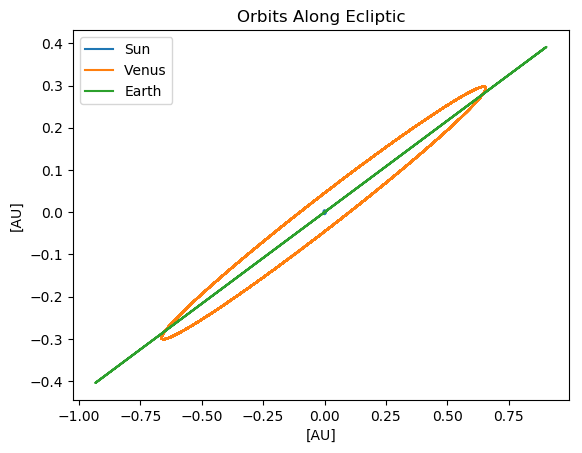

In [10]:
plot_ecliptic()

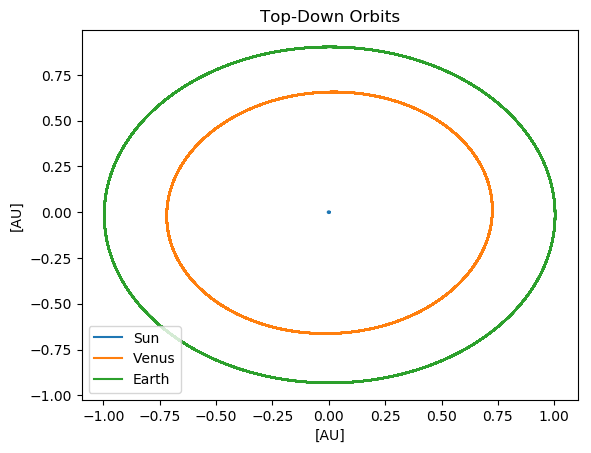

PyObject <matplotlib.legend.Legend object at 0x14914b128>

In [10]:

title("Top-Down Orbits")
plot(xsun,ysun,label="Sun")
plot(vec(pva_venus[1,1:np0]),vec(pva_venus[2,1:np0]),label="Venus")
plot(vec(pva_earth[1,1:np0]),vec(pva_earth[2,1:np0]),label="Earth")
xlabel("[AU]")
ylabel("[AU]")
legend(loc="lower left")

In [11]:
theta = atan(maximum(vec(pva_earth[3,1:np0]))-minimum(vec(pva_earth[3,1:np0])),
		 maximum(vec(pva_earth[2,1:np0]))-minimum(vec(pva_earth[2,1:np0])))
(theta)*180/pi

23.44368870506627

Reference plane is plane of Earth's orbit, equitorial/ecliptic (pointing towards Earth at Spring Equinox)

In [5]:
L_earth = cross(pva_earth[1:3], pva_earth[4:6])
L_venus = cross(pva_venus[1:3], pva_venus[4:6])

n_obs = cross(L_earth,L_venus)
n_obs/= norm(n_obs) #from one direction when both transit
x_obs, y_obs, z_obs = n_obs[1], n_obs[2], n_obs[3]

(0.22607071184005492, 0.8936832878479234, 0.3875851058405838)

In [10]:
function f(x)
    return x^2 - x - 1
end
function Df(x)
    return 2*x - 1
end
        
function Newton(f, Df, x0, eps, Nmax)
    xn = x0
    for n=0:Nmax
        fxn = f(xn)
        if abs(fxn) < eps
            println("'Found solution after'",n,"'iterations.'")
            return xn
        end
        Dfxn = Df(xn)
        if Dfxn == 0
            println("'Zero derivative. No solution found.'")
        end
        xn = xn - fxn/Dfxn
    end
end

Newton(f, Df, 1, 1e-8, 20)

'Found solution after'5'iterations.'


1.618033988749989

In [ ]:
# Finds the transit by calculating the planet positions, velocities, and accelerations from CALCEPH,
    # Finds local minimum of f(t) by solving for time when f(t) = x_bar dot v_bar = 0
    # Returns JD2 where f(jd1 + jd2) = 0
function find_times(body_id::Integer, eph::Ephem, t0, period::Float64, period_err::Float64, n_obs, N::Integer)
   # times = Float64[]
    # N = jd2 - jd1
    JD_0 = 0.0
    ff = zeros(N)
    xdotn = 0.0
    pos = zeros(3,N) # position of body relative to Sun
    # Compute functions of position and velocity wrt time:
    function calc_ffs(t)
        pva = compute(eph,JD_0,t,body_id,10,options,2)
        x = pva[1:3]; v = pva[4:6]; a = pva[7:9];
        f = dot(x, v) - (dot(x, n_obs))*(dot(v, n_obs))
        Df = dot(v, v) + dot(x, a) - (dot(v, n_obs))^2 - (dot(x, n_obs)*dot(a, n_obs))
        #Df *= ( 3600 * 24 / 1)
        return f, Df, dot(x, n_obs), x
    end
    # Computing minimum sky separation of planet wrt star for all JDs
    dt =  (jd2 - jd1)/(N-1)
    JD = zeros(N)
    i_min = 1
    ff_min = Inf
    for i=1:N
        JD[i] = jd1 + dt*(i-1)
        JD_0 = JD[i]
        ff[i], Df, xdotn, pos[:,i] = calc_ffs(0.0)
    # Estimate of transit time:
            # Df > 0 for transit occuring; 
            # xdotn > 0 for planet in front of star as seen by observer; 
            # local minimum value over entire range (i.e. when close to zero)
        if (Df > 0) && (xdotn > 0) && (abs(ff[i]) < ff_min)
            i_min = i 
            ff_min = abs(ff[i])
        end
    end
    #println("Estimated Transit Time: ", JD[i_min])
#   Refine initial guess using linear approx
    JD_0 = JD[i_min]
    JD_n = 0.0
    JD_n1 = JD_n + 1
    JD_n2 = JD_n + 2
    iter = 0
    ITMAX = 6
    for n=0:ITMAX
        JD_n2 = JD_n1
        JD_n1 = JD_n
        while JD_n > 1
            JD_n -= 1.0
            JD_0 += 1.0
        #println(JD_n," ",JD_0)
        end
        while JD_n < 0
            JD_n += 1.0
            JD_0 -= 1.0

        end
        f_n, Df_n, xdotn, x = calc_ffs(JD_n)
    #println(f_n," ", f_n/Df_n, " ", JD_n)
        JD_n -= f_n/Df_n 
        # Break out if we have reached maximum iterations, or if
              # current transit time estimate equals one of the prior two steps:
        if (JD_n == JD_n1) || (JD_n == JD_n2)
            break
        end          
    end
    JD_tt = JD_0 + JD_n
    #push!(times, JD_tt)
    
    #println("Refined Transit Time: ", JD_tt)
    return JD, ff, i_min, pos, JD_tt
end

In [ ]:
test = 365 

#t0[1] = 2.4332825e6

# Compute the TTVs of both bodies:
i=1
JD_venus,ff_venus,i_min_venus,pos_venus,tt_venus = find_transit(2,eph,t0[i],t0[i]+test,n_obs,test)
JD_earth,ff_earth,i_min_earth,pos_earth,tt_earth = find_transit(3,eph,t0[i],t0[i]+test,n_obs,test)
#end
#JD_earth, ff_earth, i_min_earth = find_transit(3, eph, t0[i], t0[i]+365, n_obs, 365)

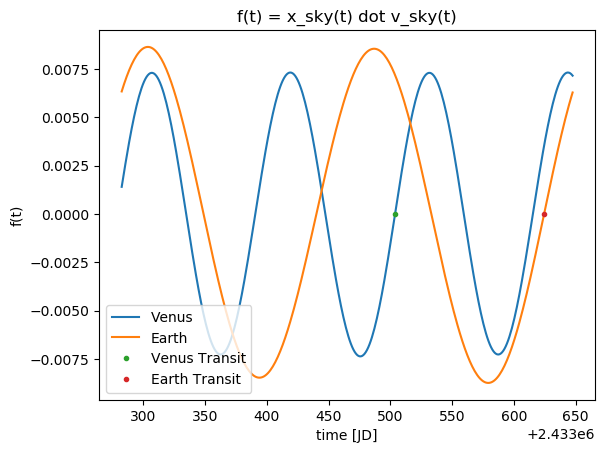

PyObject <matplotlib.legend.Legend object at 0x149bc2e48>

In [16]:
title("f(t) = x_sky(t) dot v_sky(t)")
plot(JD_venus, ff_venus, label="Venus")
plot(JD_earth, ff_earth, label="Earth")
# plot(JD_venus[i_min_venus], ff_venus[i_min_venus], ".",label="Venus Transit")
# plot(JD_earth[i_min_earth], ff_earth[i_min_earth], ".",label="Earth Transit")
plot(tt_venus, 0, ".",label="Venus Transit")
plot(tt_earth, 0, ".",label="Earth Transit")
ylabel("f(t)")
xlabel("time [JD]")
legend(loc="lower left")

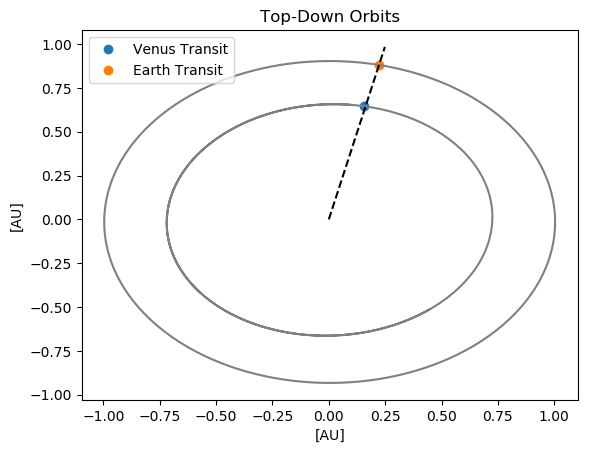

PyObject Text(24.0, 0.5, '[AU]')

In [17]:
title("Top-Down Orbits")
#plot(xsun,ysun,label="Sun")
plot(pos_venus[1,i_min_venus], pos_venus[2,i_min_venus],"o",label="Venus Transit")
plot(pos_earth[1,i_min_earth], pos_earth[2,i_min_earth],"o",label="Earth Transit")
plot(pos_venus[1,:], pos_venus[2,:],color=:grey)
plot(pos_earth[1,:], pos_earth[2,:],color=:grey)
plot([0,x_obs*1.1], [0,y_obs*1.1], "k--")
legend(loc="upper left")
xlabel("[AU]")
ylabel("[AU]")
#plot(JD_earth, ff_earth, label="Earth")

In [12]:
JD_venus,ff_venus,i_min_venus,pos_venus,tt_venus = find_transit(2,eph,t0[P_venus],t0[P_venus]+365,n_obs,365)
JD_earth,ff_earth,i_min_earth,pos_earth,tt_earth = find_transit(3,eph,t0[P_earth],t0[P_earth]+365,n_obs,365)

UndefVarError: UndefVarError: P_venus not defined

In [13]:
# Find subsequent transit times by shifting time frame by 1 planetary period
function find_times(body_id, eph, t0, Period, P_err, n_obs, N)
    times = Float64[]
    t_final = t0[end]
    i=1
    JD_,ff_,i_min_,pos_,tt_ = find_transit(body_id,eph,t0[i],t0[i]+Period,n_obs,1000)
    push!(times, tt_)
    
    while tt_ < t_final
        t_start = tt_+Period-P_err
        t_end = tt_+Period+P_err
        JD_,ff_,i_min_,pos_,tt_ = find_transit(body_id,eph,t_start,t_end,n_obs,N)
        push!(times, tt_)
    end
    return times
end

find_times (generic function with 1 method)

In [119]:
# takes diff b/w successive transit times and 
function plot_ttvs(body_id, eph, t0, Period, P_err, n_obs, N)
    tts = find_times(body_id, eph, t0, Period, P_err, n_obs, N)
    diff_tts = tts[2:end].-tts[1:end-1]
    mean_tts = mean(diff_tts)
    ttvs = tts.-mean_tts.*collect(0:1:length(tts)-1)
    mean_ttvs = mean(ttvs)
    years = (tts.-2435000)./365.25
#     return tts
    plot(years,ttvs.-mean_ttvs)
    xlabel("Years")
    ylabel("TTVs")
end

plot_ttvs (generic function with 1 method)

In [14]:
P_earth = 365
P_venus = 225
P_err = 2

tt_earth = find_times(3, eph, t0, P_earth, P_err, n_obs, 10)
tt_venus = find_times(2, eph, t0, P_venus, P_err, n_obs, 10)

ntearth = length(tt_earth)
ntvenus = length(tt_venus)

# Find ttvs via linear regression of transit time data
# accounts for missing transits (noncontinuous) by rounding [difference in consecutive transit times/Period]
function find_ttvs(tt, Period; sigma_x = ones(length(tt)))
    nt = length(tt)
    x = zeros(2,nt)
    x[1,1:nt] .= 1.0
    x[2,1] = 0.0 # for fitting time of first transit
    for i=2:nt
        x[2,i] = x[2,i-1] + round((tt[i]-tt[i-1])/Period) 
    end
        
    coeff, cov = regress(x, tt, sigma_x)
    # coeff[1] = best linear fit approx of first tt, coeff[2] = average period
    ttv = tt .- coeff[1].*vec(x[1,1:nt]) .- coeff[2].*vec(x[2,1:nt])
    return coeff, ttv
end

coeff_earth, ttv_earth = find_ttvs(tt_earth, P_earth)
coeff_venus, ttv_venus = find_ttvs(tt_venus, P_venus)

# writedlm("ttv_earth.txt", zip(tt_earth,ttv_earth))
# writedlm("ttv_venus.txt", zip(tt_venus,ttv_venus))

([2.4335e6, 224.701], [-0.00102013, -0.000452962, 0.00166548, -0.000356764, -0.00190131, 0.00210235, 0.00233996, 0.000967515, -0.00180005, -0.00255334  …  0.00276007, 0.00222169, -0.000116127, -0.00179748, -0.00169774, 0.00163908, 9.52233e-5, -0.00170739, 0.000886107, 0.00151221])

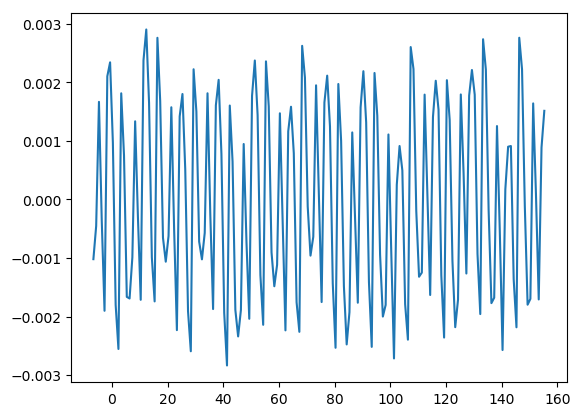

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14aca0240>

In [31]:
plot(((tt_venus.-2435000)./coeff_venus[2]), ttv_venus)

In [124]:
tt_earth = find_times(399, eph, t0, P_earth, P_err, n_obs, 10)
tt_emb = find_times(3, eph, t0, P_earth, P_err, n_obs, 10)
tt_moon = find_times(301, eph, t0, P_earth, P_err, n_obs, 10)

100-element Array{Float64,1}:
 2.433624388290972e6 
 2.433989766945824e6 
 2.4343547682580054e6
 2.434720237188257e6 
 2.435085464554211e6 
 2.4354505604527285e6
 2.435816080937655e6 
 2.43618115285356e6  
 2.4365463934904896e6
 2.43691184342484e6  
 2.437276840769917e6 
 2.4376422471043863e6
 2.4380075531823984e6
 ⋮                   
 2.4657670333854943e6
 2.4661320806818814e6
 2.466497606532017e6 
 2.4668626906114807e6
 2.46722790457321e6  
 2.467593398467723e6 
 2.4679583966574357e6
 2.468323791874524e6 
 2.468689128096996e6 
 2.4690541359060123e6
 2.4694196405143556e6
 2.469784791477202e6 

In [125]:
f_masses = (tt_earth .- tt_emb)./(tt_emb .- tt_moon)
mean(f_masses)

0.012302902053655956

In [55]:
# Find Jupiter....

In [46]:
data1 = readdlm("ttv_venus.txt")
tt1 = vec(data1[:,1]); ttv1 = vec(data1[:,2])

data2 = readdlm("ttv_earth.txt")
tt2 = vec(data2[:,1]); ttv2 = vec(data2[:,2])


nt1 = length(tt1)
t01 = coeff_venus[1]; per1 = coeff_venus[2]

nt2 = length(tt2)
t02 = coeff_earth[1]; per2 = coeff_earth[2];

In [61]:
# best fit linear transit times w/o ttvs
t1  = collect(t01 .+ per1 .* range(0,stop = nt1-1,length = nt1)) 
t2  = collect(t02 .+ per2 .* range(0,stop = nt2-1,length = nt2))
    # Best-fit linear transit times:
tt0 = [t1;t2] # appends t2 times to t1 times
weight = ones(nt1+nt2) #assigns each data point stat weight d.t. noise [will add noise later]
# Actual transit times:
tt = [tt1;tt2]

# Okay, now let's do a 2-planet fit:
# initial params defined for both planets
# mass ratio, period, initial transit time, e*cos(omega), e*sin(omega)
params = [3e-6,per1,t01,0.01,0.01,3e-6,per2,t02,0.01,0.01] 
println("Initial parameters: ",params)


Initial parameters: [3.0e-6, 224.701, 2.4335e6, 0.01, 0.01, 3.0e-6, 365.256, 2.43362e6, 0.01, 0.01]


([2.4335e6, 2.43373e6, 2.43395e6, 2.43418e6, 2.4344e6, 2.43463e6, 2.43485e6, 2.43508e6, 2.4353e6, 2.43553e6  …  2.4665e6, 2.46686e6, 2.46723e6, 2.46759e6, 2.46796e6, 2.46832e6, 2.46869e6, 2.46905e6, 2.46942e6, 2.46978e6], [2.4335e6, 2.43373e6, 2.43395e6, 2.43418e6, 2.4344e6, 2.43463e6, 2.43485e6, 2.43508e6, 2.4353e6, 2.43553e6  …  2.4665e6, 2.46686e6, 2.46723e6, 2.46759e6, 2.46796e6, 2.46832e6, 2.46869e6, 2.46905e6, 2.46942e6, 2.46978e6])

In [75]:
nplanet = 2
ntrans = [nt1,nt2]
n1, n2 = ntrans; n1

163

In [77]:
typeof(tt1)

Array{Float64,1}

In [82]:
include("ttv_nplanet.jl")
function ttv_wrapper(nplanet::Int64, ntrans::Vector{Int64}, tt, data::Array{Float64, 1})
function 
    # These lines need modification for different choices of parameters:
#     nplanet = 2
#     ntrans = [n1,n2]
    while nplanet ==2
        n1, n2 = ntrans
    end
    while nplanet ==3
        n1, n2, n3 = ntrans
    end
    jmax = 5
    # Call ttv_nplanet:
    ttv = ttv_nplanet(nplanet, jmax, ntrans, params)
    # We measure transit times, not TTVs, so add
    # back in the linear ephemeris:
    # n1 = ntrans[1]
    t01 = params[3]
    per1 = params[2]
    ttv1 = collect(range(t01,stop = t01+per1*(n1-1),length = n1))
    for i=1:n1
     ttv1[i]+= ttv[1,i]
    end
    # n2 = ntrans[2]
    t02 = params[8]
    per2 = params[7]
    ttv2 = collect(range(t02,stop = t02+per2*(n2-1),length = n2))
    for i=1:n2
      ttv2[i] += ttv[2,i]
    end
    # If transit times of additional planets were observable
    # these would need to be added in.
    #println("param2: ",param)
    return [ttv1;ttv2]
end

ttv_wrapper (generic function with 3 methods)

In [ ]:
ttv_wrapper(2, ntrans, tt, params)

In [64]:
function chisquare(nplanet, params)
    chisq = 0.0
    while nplanet ==2
#         tt_model = ttv_wrapper2(tt0,param)
#         for j=1:length(tt0)
#           chisq += (tt[j]-tt_model[j])^2/sigtt[j]^2
#         end
#         println(nplanet)
        return chisq
    end
    while nplanet==3
#         tt_model = ttv_wrapper3(tt0,param)
#         for j=1:length(tt0)
#           chisq += (tt[j]-tt_model[j])^2/sigtt[j]^2
#         end
#         println(nplanet)
        return chisq
    end
end




chisquare (generic function with 1 method)

In [65]:
chisquare(3,params)

3


0.0

In [ ]:


	pos_earth_test = zeros(3)  # Position of Earth relative to Sun
	rsky_earth_test = zeros(3)

	pos_venus_test = zeros(3)
	rsky_venus_test = zeros(3)
	nearth = 0
	nvenus = 0

	ntearth=length(tt_earth)
	x = zeros(2,ntearth); sx=ones(ntearth)
	x[1,1:ntearth]=1.0
	x[2,1:ntearth]=range(0,stop = ntearth-1,length = ntearth)
	coeff,cov = regress(x,tt_earth,sx)
	ttv_earth = tt_earth - coeff[1]*vec(x[1,1:ntearth]) - coeff[2]*vec(x[2,1:ntearth])
	ntvenus=length(tt_venus)
	x = zeros(2,ntvenus); sx=ones(ntvenus)
	x[1,1:ntvenus]=1.0
	x[2,1:ntvenus]=range(0,stop = ntvenus-1,length = ntvenus)
	coeff = regress(x,tt_venus,sx)
	ttv_venus = tt_venus - coeff[1]*vec(x[1,1:ntvenus]) - coeff[2]*vec(x[2,1:ntvenus])
	#writedlm("ttv_earth_bary.txt",zip(tt_earth,ttv_earth))
	writedlm("ttv_earth.txt",zip(tt_earth,ttv_earth))
	writedlm("ttv_venus.txt",zip(tt_venus,ttv_venus))
	return tt_earth,tt_venus,ttv_earth,ttv_venus
end
earth_venus_ttv()


In [ ]:
# Okay, so now add noise to the TTVs of both bodies:

E_ttv = readdlm("agol_ttv_earth.txt") #Earth
V_ttv = readdlm("agol_ttv_venus.txt") #Venus
#Transit Times
E_tt = E_ttv[:,1] .* 24*60; V_tt = V_ttv[:,1].* 24*60; #days --> minutes
#Transit Timing Variations
E_tv = E_ttv[:,2] .* 24 * 60 ; V_tv = V_ttv[:,2] .*24 * 60 ;#days --> minutes
E_tt

dom1 = Domain(tt1) ; dom2 = Domain(V_tt)
rng = MersenneTwister(0)
E_nvar = Statistics.std(E_tv) ; V_nvar = Statistics.std(V_tv)
E_noise = randn(rng, length(E_tv)) * E_nvar/2 ; V_noise = randn(rng, length(V_tv)) * V_nvar/2
E_tv_noised = E_noise + E_tv ; V_tv_noised = V_noise + V_tv
data1 = Measures(E_tv_noised, 1.0) ; data2 = Measures(V_tv_noised, 1.0)

subplot(211) 
suptitle("Transit Timing Variations") # Supe title, title for all subplots combine
plot(V_tt, V_tv, color = "k")
plot(V_tt, V_tv_noised, label = "+noise")
ylabel("Venus [min]"); legend()
subplot(212)
plot(E_tt, E_tv, color = "k")
plot(E_tt, E_tv_noised, label = "+noise")
ylabel("Earth [min]"); legend()
xlabel("transit times")
#ylabel("timing variations [minutes]") #legend();
plot(E_tt, E_tv, label = "Earth", color = "k")
errorbar(E_tt,E_tv,yerr = E_nvar, label ="Std", fmt = ".", alpha = 0.75)
legend();xlabel("transit times");ylabel("timing variations [minutes]")

In [ ]:
TTVFaster.compute_ttv!(5,,,V_tt,E_tt,5,0.2 )

data1 = readdlm("agol_ttv_venus.txt")
tt1 = vec(data1)
nt1 = length(tt1) #number of transits
x = zeros(2,nt1)

par_mcmc,chi_mcmc = fit_mysteryplanet3()

